# Data Analysis and Feature Engineering

In [1]:
import numpy as np, pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.metrics import r2_score

%matplotlib inline
%config IPCompleter.greedy=True

In [2]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore',category=FutureWarning)

In [3]:
train = pd.read_csv('datasets/train_cleaned.csv')

In [4]:
pd.set_option('display.max_columns', 731)
pd.set_option('display.max_rows', 161)

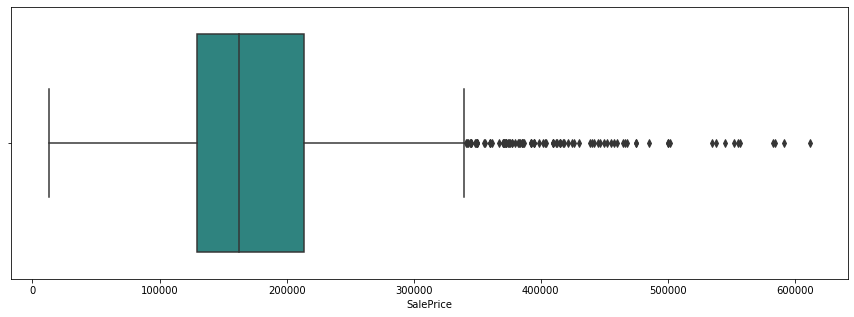

In [5]:
plt.figure(figsize = (15, 5))
sns.boxplot('SalePrice', data = train, palette = 'viridis');

In [6]:
train['SalePrice'].describe()

count      2051.000000
mean     181469.701609
std       79258.659352
min       12789.000000
25%      129825.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: SalePrice, dtype: float64

In [7]:
# multicollinearity

In [8]:
correlations = train.corr()
cut_off = 0.5
high_corrs = correlations[correlations.abs() > cut_off][correlations.abs() != 1].unstack().dropna().to_dict()
high_corrs = pd.Series(high_corrs, index = high_corrs.keys())
high_corrs = high_corrs.reset_index()
high_corrs = pd.DataFrame(high_corrs)
high_corrs.columns = ['Attribute_1', 'Attribute_2','Correlations']
high_corrs['Correlations'] = high_corrs['Correlations'].drop_duplicates(keep ='first')
high_corrs = high_corrs.dropna().sort_values(by = 'Correlations', ascending = False)

In [9]:
# identify multicollinearity
high_corrs

,Attribute_1,Attribute_2,Correlations
95,Garage Yr Blt,Garage Cond,0.954532
114,Garage Qual,Garage Cond,0.950124
94,Garage Yr Blt,Garage Qual,0.947216
100,Garage Cars,Garage Area,0.893226
119,Pool Area,Pool QC,0.867751
89,Fireplaces,Fireplace Qu,0.859734
66,Gr Liv Area,TotRms AbvGrd,0.813333
49,Total Bsmt SF,1st Flr SF,0.808351
10,Overall Qual,SalePrice,0.800207
2,Overall Qual,Exter Qual,0.740257


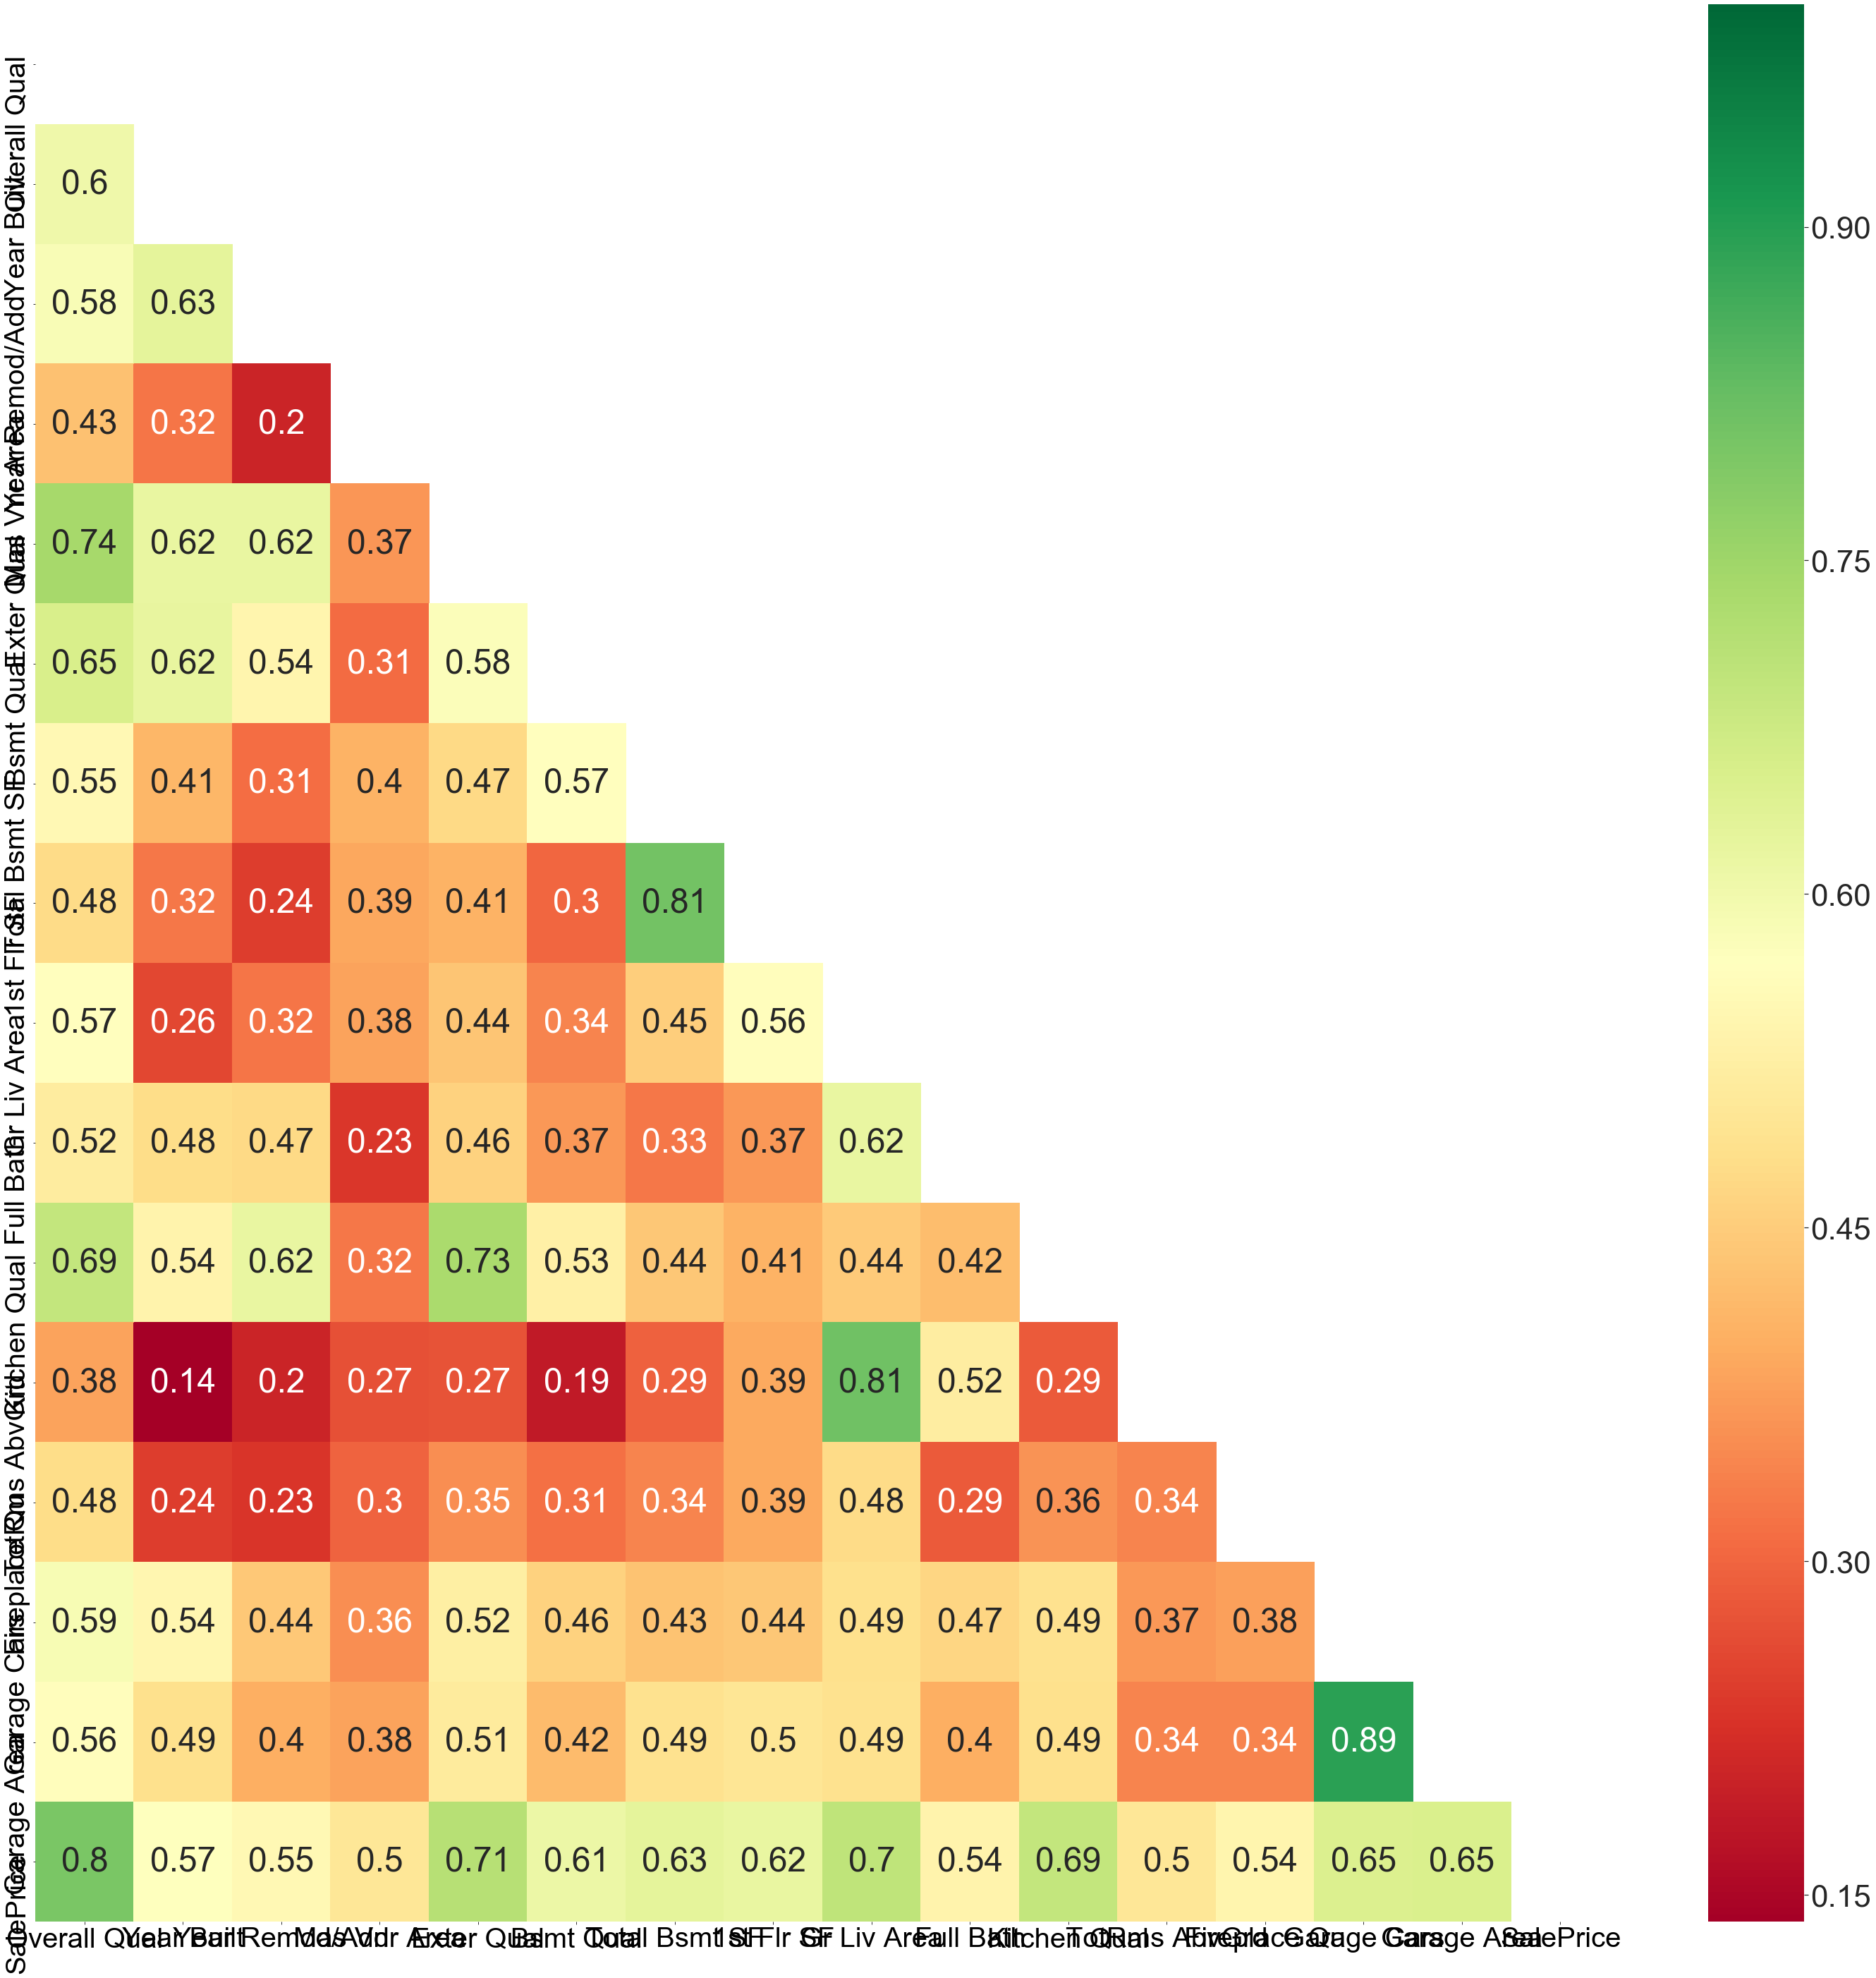

In [10]:
corrmat = train.corr()
best_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]

# Set the default matplotlib figure size to 20x14:
fix, ax = plt.subplots(figsize=(50,50))
sns.set(font_scale=4)

# Generate a mask for the upper triangle
mask = np.zeros_like(train[best_corr_features].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns.
ax = sns.heatmap(train[best_corr_features].corr(), mask=mask, ax=ax, cmap="RdYlGn", annot=True)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=40)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=40)

plt.show()

Through the correlation matrix, I discovered that there are many independent variables that are highly correlated with each other which shows the existence of multicollinearity. Hence, some of the highly correlated features will be dropped except for those that are higly correated with sale price.

In [11]:
train.corr().index[abs(train.corr()["SalePrice"])>0.5]

Index(['Overall Qual', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'Exter Qual', 'Bsmt Qual', 'Total Bsmt SF', '1st Flr SF', 'Gr Liv Area',
       'Full Bath', 'Kitchen Qual', 'TotRms AbvGrd', 'Fireplace Qu',
       'Garage Cars', 'Garage Area', 'SalePrice'],
      dtype='object')

In [12]:
# drop variables with multi colinearity
train.drop(columns=['Garage Yr Blt','Garage Cond','Garage Qual','Heating QC','Pool QC','Fireplaces'],inplace=True)

In [13]:
sorted(train.corr().to_dict()['SalePrice'].items(), key=lambda x: x[1], reverse=True)

[('SalePrice', 1.0),
 ('Overall Qual', 0.8002068702531417),
 ('Exter Qual', 0.7121457238137783),
 ('Gr Liv Area', 0.6970384443056628),
 ('Kitchen Qual', 0.692336353107091),
 ('Garage Area', 0.6502090480849064),
 ('Garage Cars', 0.6482247414107218),
 ('Total Bsmt SF', 0.6293030962146711),
 ('1st Flr SF', 0.6184861410533946),
 ('Bsmt Qual', 0.61218790160043),
 ('Year Built', 0.5718488959135772),
 ('Year Remod/Add', 0.5503696488195575),
 ('Fireplace Qu', 0.538925051153872),
 ('Full Bath', 0.5379691021121198),
 ('TotRms AbvGrd', 0.5040143180735341),
 ('Mas Vnr Area', 0.5035287654160421),
 ('Bsmt Exposure', 0.4259337861210455),
 ('BsmtFin SF 1', 0.4238559133946774),
 ('Open Porch SF', 0.33347602979205326),
 ('Wood Deck SF', 0.3264897021896583),
 ('Lot Frontage', 0.3206655024441277),
 ('Lot Area', 0.29656583236677914),
 ('Bsmt Full Bath', 0.28333232871961533),
 ('Half Bath', 0.2830006979883375),
 ('2nd Flr SF', 0.24845153013114143),
 ('Bsmt Cond', 0.2250753821197822),
 ('Bsmt Unf SF', 0.1908

In [14]:
cont_features = ['Overall Qual','Exter Qual','Gr Liv Area','Kitchen Qual','Garage Area','Garage Cars','Total Bsmt SF','1st Flr SF','Bsmt Qual','Year Built','Year Remod/Add','Fireplace Qu','Full Bath','TotRms AbvGrd','Mas Vnr Area']

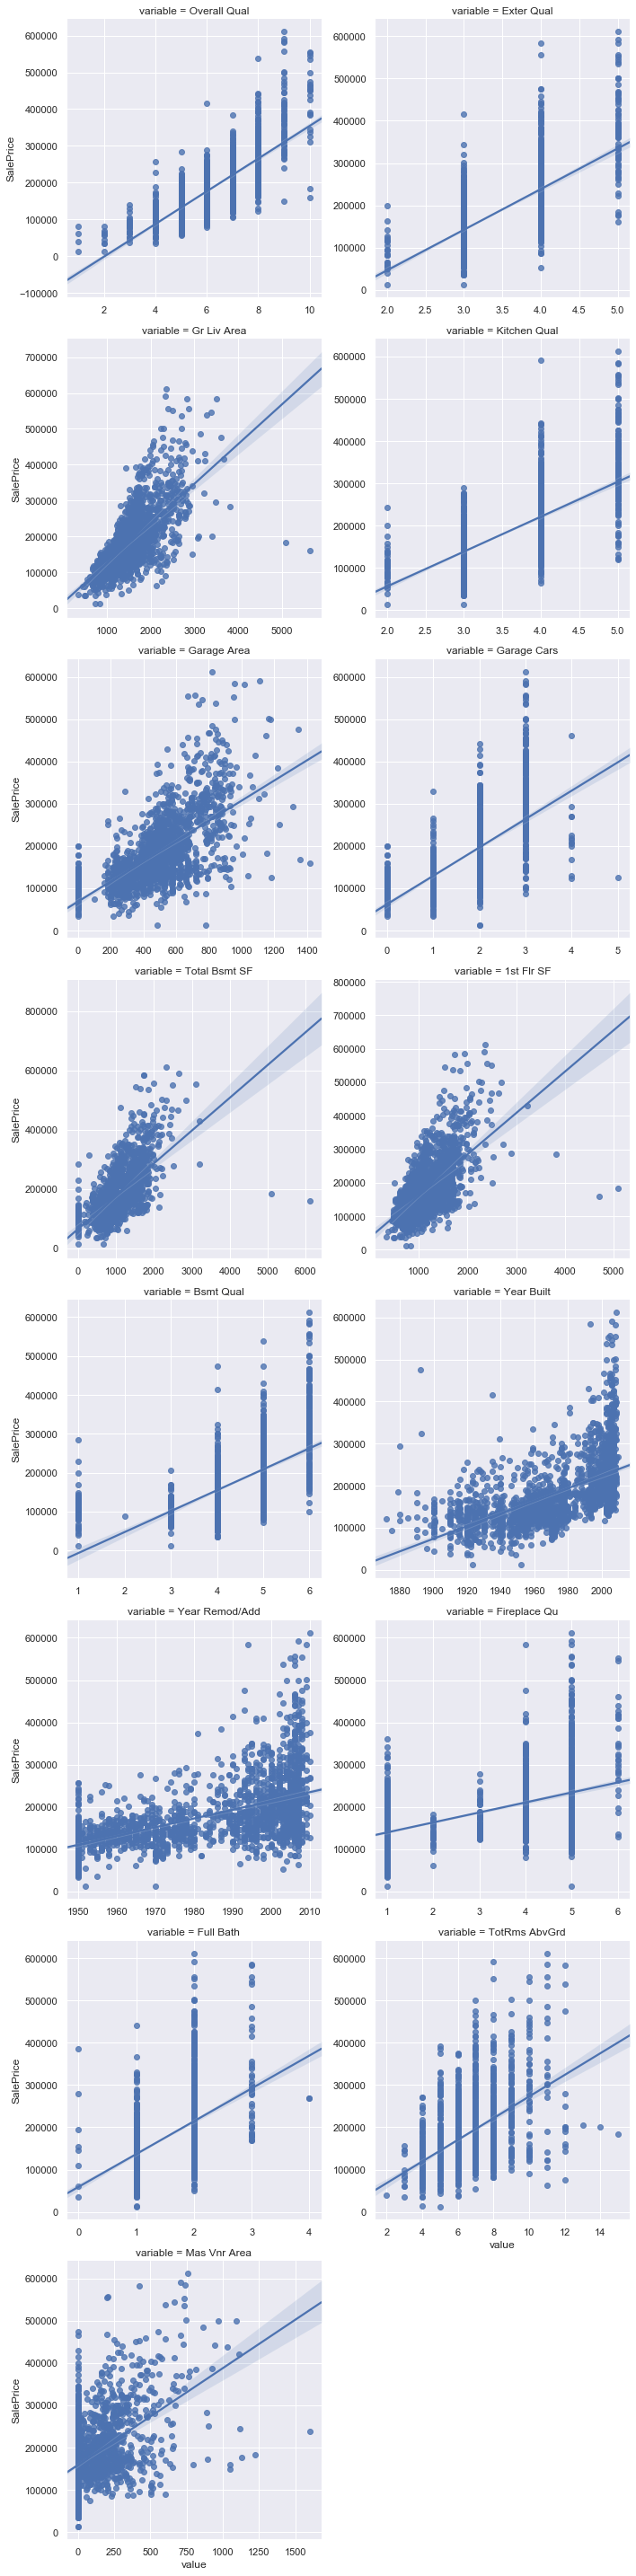

In [58]:
sns.set(font_scale=1)
f = pd.melt(train, id_vars = 'SalePrice', value_vars = cont_features)
g = sns.FacetGrid(f, col = "variable",  col_wrap=2, sharex=False, sharey=False, size=5)
s = g.map(sns.regplot, 'value', 'SalePrice');

In [17]:
# isolate all features that have an "object" dtypes and assign a variable
categorical = [i for i in train if train[i].dtype == 'O']

/Users/kenricklow/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/kenricklow/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


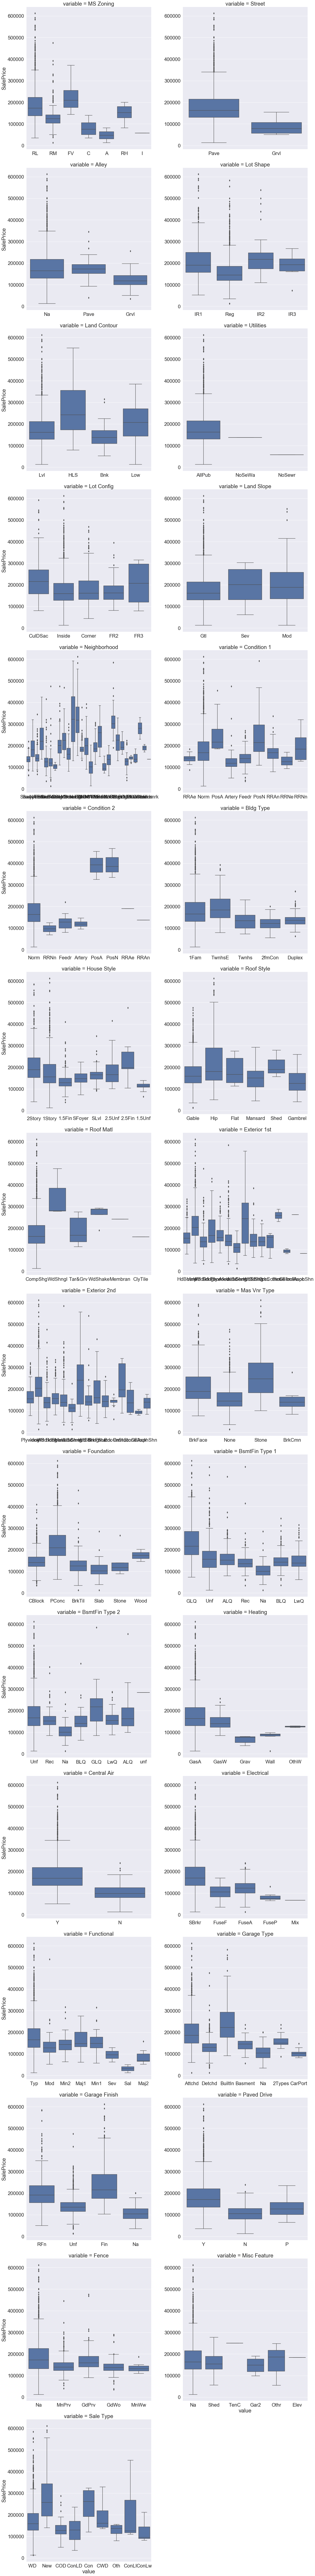

In [62]:
sns.set(font_scale=2)
f = pd.melt(train, id_vars = 'SalePrice', value_vars = categorical)
g = sns.FacetGrid(f, col = "variable",  col_wrap = 2, sharex = False, sharey = False, size = 10)
g.map(sns.boxplot, 'value', 'SalePrice')

In [18]:
# assign variable to the dataframe of the list of categorical features
cat_feature = train[categorical]

In [19]:
# one-hot encoding for all categorical variables
cat_features = pd.concat([pd.get_dummies(train[feat],prefix=feat) for feat in train if train[feat].dtype == 'O'], axis=1)

In [20]:
# concatenate continuous and categorical features into 1 dataframe
features = pd.concat([train[cont_features],cat_features],axis=1)

In [21]:
# take a look at the number of features and observations of the whole dataframe
features.shape

(2051, 225)

In [22]:
# create my X and y variables
X_base = features
y = train['SalePrice']

In [23]:
# split x and y variables into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_base, y, random_state=0)

In [24]:
# fit a standard scaler to X_train and transform both X_train and X_test
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

Instantiate a Lasso.

In [25]:
lasso = LassoCV()

In [26]:
# baseline R^2 score for the model
cross_val_score(lasso, X_train, y_train, cv=10).mean()

0.86064691472355

In [27]:
# fit lasso using training set
lasso.fit(X_train,y_train)
# training score
print("Training set score: {:.2f}".format(lasso.score(X_train, y_train)))
# testing score
print("Test set score: {:.2f}".format(lasso.score(X_test, y_test)))
print("Number of features used: {}".format(np.sum(lasso.coef_ != 0)))

Training set score: 0.91
Test set score: 0.81
Number of features used: 99


The baseline model using lasso shows signs of overfitting as the training and test score are 10 points apart with 99 features used. Hence, I will proceed to drop more features using RFE for feature selection.

In [28]:
# feature extraction
rfe = RFE(lasso,n_features_to_select=25)
rfe_fit = rfe.fit(X_train,y_train)
# print("Num Features: %d" % rfe_fit.n_features_)
# print("Selected Features: %s" % rfe_fit.support_)
# print("Feature Ranking: %s" % rfe_fit.ranking_)
dfsupport = pd.DataFrame(rfe_fit.support_)
dfranking = pd.DataFrame(rfe_fit.ranking_)
dfcolumns = pd.DataFrame(X_base.columns)
# concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfsupport,dfranking],axis=1)
# naming the dataframe columns
featureScores.columns = ['Feature','Selection','Rank']

In [29]:
# isolate the top 25 features into a dataframe
top_25 = featureScores.loc[featureScores['Selection']==True]

In [30]:
# make the top 25 features into a list
best_feature = [i for i in top_25['Feature']]

In [31]:
best_feature.remove('Neighborhood_GrnHill')
best_feature.remove('Misc Feature_Elev')

In [33]:
# create a new X variable with our best features
X = features[best_feature]

In [34]:
# split X and y variables into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [35]:
# fit a standard scaler to X_train and transform both X_train and X_test
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [36]:
# R^2 score for the model
cross_val_score(lasso, X_train, y_train, cv=10).mean()

0.8524932288801408

In [37]:
# fit lasso using training set
model_lasso = lasso.fit(X_train,y_train)
# training score
print("Training set score: {:.2f}".format(lasso.score(X_train, y_train)))
# testing score
print("Test set score: {:.2f}".format(lasso.score(X_test, y_test)))
print("Number of features used: {}".format(np.sum(lasso.coef_ != 0)))

Training set score: 0.87
Test set score: 0.81
Number of features used: 23


In [38]:
pred_lasso = lasso.predict(X_test)

Instantiate a linear and ridge regression

In [39]:
lr = LinearRegression()

In [40]:
# R^2 score for the model
cross_val_score(lr, X_train, y_train, cv=10).mean()

0.8526855304673898

In [41]:
# fit linear using training set
model_lr = lr.fit(X_train,y_train)
# training score
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
# testing score
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))
print("Number of features used: {}".format(np.sum(lr.coef_ != 0)))

Training set score: 0.87
Test set score: 0.81
Number of features used: 23


In [42]:
pred_lr = lr.predict(X_test)

In [43]:
ridge = RidgeCV()

In [44]:
# R^2 score for the model
cross_val_score(ridge, X_train, y_train, cv=10).mean()

0.8529567784204237

In [45]:
# fit ridge using training set
model_ridge = ridge.fit(X_train,y_train)
# training score
print("Training set score: {:.2f}".format(ridge.score(X_train, y_train)))
# testing score
print("Test set score: {:.2f}".format(ridge.score(X_test, y_test)))
print("Number of features used: {}".format(np.sum(ridge.coef_ != 0)))

Training set score: 0.87
Test set score: 0.81
Number of features used: 23


All 3 models return the the same result when 23 of the carefuly selected features are selected. The test score still performed slightly worse than the training score.

In [46]:
pred_ridge = ridge.predict(X_test)

In [47]:
test = pd.read_csv('datasets/test_cleaned.csv')

In [48]:
# isolate all features that have an "object" dtypes and assign a variable
categorical_test = [i for i in test if test[i].dtype == 'O']

In [49]:
# assign variable to the dataframe of the list of categorical features
cat_feature_test = test[categorical_test]

In [50]:
# one-hot encoding for all categorical variables
cat_features_test = pd.concat([pd.get_dummies(test[feat],prefix=feat) for feat in test if test[feat].dtype == 'O'], axis=1)

In [51]:
cont_features_test = test.select_dtypes(exclude=['object'])

In [52]:
# concatenate continuous and categorical features into 1 dataframe
test = pd.concat([cont_features_test,cat_features_test],axis=1)

In [53]:
prediction = model_lasso.predict(test[best_feature])

In [54]:
# for submission
submission = pd.DataFrame()
submission['Id'] = test['Id']
submission['SalePrice'] = prediction
submission.head()

,Id,SalePrice
0,2658,6.370630e+07
1,2718,7.794232e+07
2,2414,5.127498e+07
3,1989,4.502495e+07
4,625,5.995279e+07


In [55]:
# export file
submission.to_csv('datasets/submission.csv',index=False)